In [1]:
from fipy import CellVariable, Grid2D, DiffusionTermCorrection, TransientTerm
from fipy.tools import numerix as nx
from scipy.optimize import curve_fit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as patches

center: 18
I per wdith = 0.011207510088197965 mA/um
I = 0.7677144410415605 mA
V = -0.00757538123838114 V
R = -9.867446583528633 Ohm
R_theo = 141.52521293111582 Ohm


fitting params: [ 0.66860662 -0.0732189   0.35289088]
lambda = 328.3635144959828 um


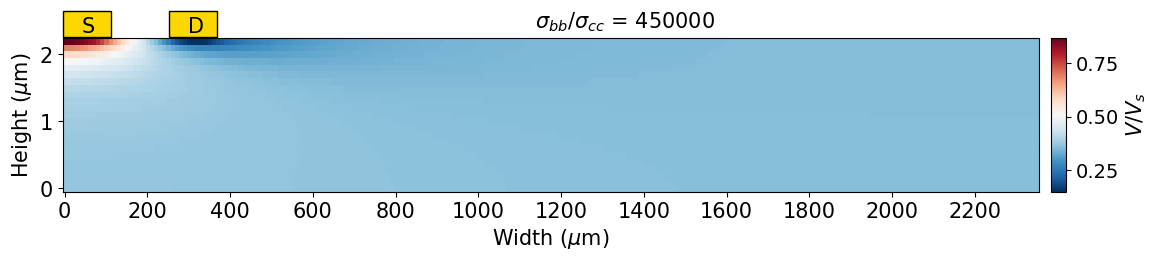

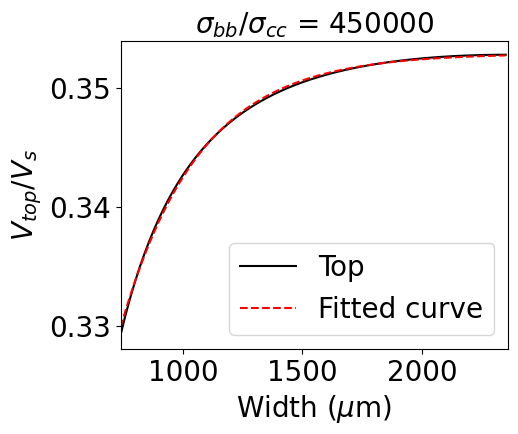

In [17]:
Type = "exp"

width = 68.5  #um
Lx, Ly = 2360, 2.3  #um
dx, dy = 10, 0.1  #um
size = 100
steps = 10

sigma_x = 0.0148  #S/um

V1_p = 920   #um
V2_p = 1250   #um

invratio = 450000

ratio = 1/invratio
nx_cells, ny_cells = round(Lx/dx), round(Ly/dy)

sigma_y = sigma_x*ratio
D = ((sigma_x, 0.0), (0.0, sigma_y))

timeStepDuration = 10*dx**2 / (2 * np.min([sigma_x, sigma_y]))

mesh = Grid2D(nx=nx_cells, ny=ny_cells, dx=dx, dy=dy)

V = CellVariable(name="V", mesh=mesh, value=0.)

x_faces = mesh.faceCenters[0]
y_faces = mesh.faceCenters[1]
top = (y_faces > Ly - 0.5*dy)

top_np = np.array(top)

if Type == "Short":

    w1, w2 = 650, 1650

elif Type =="exp":

    w1, w2 = 0, 260

else:

    w1 = 0
    w2 = Lx - size


e1 = top&(x_faces >= w1)&(x_faces <= w1+size)
e2 = top&(x_faces >= w2)&(x_faces <= (w2 + size))

U1, U2 = 1, 0  # Volts

eq = TransientTerm() == DiffusionTermCorrection((D,))

V.constrain(U1, where = e1)
V.constrain(U2, where = e2)

for step in range(steps):

    eq.solve(var=V, dt=timeStepDuration)

V_r = np.array(V).reshape(ny_cells, nx_cells)
grad_V_x = np.gradient(V_r, axis = 1)/dx
grad_V_y = np.gradient(V_r, axis = 0)/dy
I_x = -sigma_x*grad_V_x
I_y = -sigma_y*grad_V_y
center = int((w1 +w2 + size)/(2*dx))

I_per_width = np.sum(I_x[:,center])*dy
I = I_per_width*width

print("center:", center)
print("I per wdith =", I_per_width*1000, "mA/um")
print("I =", I*1000, "mA")

V1 = V_r[int(Ly/dy) - 1][int(V1_p/10)]
V2 = V_r[int(Ly/dy) - 1][int(V2_p/10)]

V_drop = V1 - V2 
R = V_drop/I
R_theo = (1/sigma_x)*(V2_p - V1_p)/(Ly*width)

print("V =", V_drop, "V")
print("R =", R, "Ohm")
print("R_theo =", R_theo, "Ohm")

fig, ax = plt.subplots(figsize=(15, 2))
fig.suptitle(r"$\sigma_{bb}/\sigma_{cc}$ = %d"%(invratio), fontsize = 15, y=1.02)
im = ax.imshow(V_r, cmap="RdBu_r", aspect="auto")
ax.set_xlabel(r"Width ($\mu$m)", fontsize = 15)
ax.set_ylabel(r"Height ($\mu$m)", fontsize = 15)
ax.tick_params(axis = "x", labelsize = 15)
ax.tick_params(axis = "y", labelsize = 15)

reduced_cut_Lx = (Lx - (Lx % 200))/dx
x_thicks = np.linspace(0, reduced_cut_Lx, int(reduced_cut_Lx/20) + 1)

ax.set_xticks(x_thicks)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x*dx)}"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x*dy)}"))
ax.invert_yaxis()
cbar = plt.colorbar(im, ax=ax, shrink = 1, aspect=10, pad= 0.01)
cbar.set_label("$V$/$V_s$", fontsize=15)
cbar.ax.tick_params(labelsize=14)


data_to_figure = (0.2227 - 0.125)*0.8407/300

rect1 = patches.Rectangle((0.125 + data_to_figure*w1, 0.884), 0.032, 0.13,     # x,y,w,h in figure coords
                         transform=fig.transFigure,
                         facecolor="gold", edgecolor="black", clip_on=False, zorder=1)
ax.add_patch(rect1)

rect2 = patches.Rectangle((0.125 + data_to_figure*w2, 0.884), 0.032, 0.13,     # x,y,w,h in figure coords
                         transform=fig.transFigure,
                         facecolor="gold", edgecolor="black", clip_on=False, zorder=1)
ax.add_patch(rect2)

data_to_text = (0.1695 - 0.02)*0.8407/300

txt1 = fig.text(0.02 + data_to_text*w1, 1.035, "S", transform=ax.transAxes,
        fontsize=15, color="black", clip_on=False, zorder=2)

txt2 = fig.text(0.02 + data_to_text*w2, 1.035, "D", transform=ax.transAxes,
        fontsize=15, color="black", clip_on=False, zorder=2)


plt.savefig("Dirichlet_%d_diffusion_map_%s.pdf"%(invratio, Type), bbox_inches="tight",  dpi = 300, bbox_extra_artists = [txt1, txt2, rect1, rect2])


def tail(x, r, a, c):

    lamb = (Ly/np.pi)*np.sqrt(1/ratio)
    lamb_r = lamb*r
    
    return a*np.exp(-(x-(w2 + size))/lamb_r) + c

rsf = 74
lamb = (Ly/np.pi)*np.sqrt(1/ratio)

popt, pcov = curve_fit(tail, np.arange(nx_cells)[rsf:]*dx, V_r[round(Ly/dy) - 1][rsf:], p0 = [1, -0.1, 0.3])
print("fitting params:", popt)
print("lambda =", lamb*popt[0], "um")

fig, ax1,  = plt.subplots(1, 1, figsize=(5, 4))
ax1.set_title(r"$\sigma_{bb}/\sigma_{cc}$ = %d"%(invratio), fontsize = 20)
ax1.plot(np.arange(nx_cells)[rsf:]*dx, V_r[round(Ly/dy) - 1][rsf:], label = "Top", color = "black")
ax1.plot(np.arange(nx_cells)[rsf:]*dx, tail(np.arange(nx_cells)[rsf:]*dx, *popt), linestyle = "--", color = "red", label = "Fitted curve")
ax1.legend(fontsize=20)

# np.savetxt("Dirichlet_%d_top_line_profiles_%s.txt"%(invratio, Type), np.column_stack((np.arange(nx_cells)*dx, V_r[round(Ly/dy) - 1])))

ax1.set_xlim(0, Lx)
ax1.set_xlabel(r"Width ($\mu$m)", fontsize = 20)
ax1.set_ylabel(r"$V_{top}$/$V_s$", fontsize = 20)
ax1.tick_params(axis = "x", labelsize = 20)
ax1.tick_params(axis = "y", labelsize = 20)
ax1.set_xlim(rsf*dx, Lx)

# ax2.set_title(r"$\sigma_{yy}/\sigma_{zz}$ = %d"%(invratio), fontsize = 15)
# ax2.plot(np.arange(nx_cells)*dx, V_r[round(Ly/dy) - 1], label = "Top")
# ax2.plot(np.arange(nx_cells)*dx, V_r[int(round(Ly/dy-1)/2)], label = "Middle")
# ax2.plot(np.arange(nx_cells)*dx, V_r[0], label = "Bottom")
# ax2.set_xlim(0, Lx)
# ax2.set_xlabel(r"Width ($\mu$m)", fontsize = 15)
# ax2.set_ylabel(r"$V$/$V_s$ ($\mu$m)", fontsize = 15)
# ax2.tick_params(axis = "x", labelsize = 15)
# ax2.tick_params(axis = "y", labelsize = 15)
# fig.subplots_adjust(wspace=0.4)
# ax2.legend(fontsize=15, loc="upper right")


plt.savefig("Dirichlet_%d_line_profiles_%s.eps"%(invratio, Type), dpi = 300, bbox_inches="tight")